In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_palette(["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"])
ncolours = len(plt.rcParams['axes.prop_cycle'])
colours = [list(plt.rcParams['axes.prop_cycle'])[i]['color'] for i in range(ncolours)]
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['font.size'] = 24
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

from sklearn.preprocessing import MinMaxScaler

# Preprocessing

In [2]:
data_int = pd.read_csv('../data/data_int.csv', index_col=0)
data_auc = pd.read_csv('../data/data_auc.csv', index_col=0)
data_zauc = pd.read_csv('../data/data_zauc.csv', index_col=0)

metadata = pd.read_csv('../data/metadata_clean.csv', index_col=0)

In [3]:
data_int.head()

,0,1,2,3,4,5,6,7,8,9,...,44826,44827,44828,44829,44830,44831,44832,44833,44834,44835
19777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
19778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,933.0,907.0,0.0,0.0,3784.0,0.0,0.0,101.0,81.0,0.0
19779,0.0,0.0,0.0,0.0,622.0,0.0,0.0,0.0,0.0,0.0,...,0.0,92.0,2590.0,2349.0,2326.0,0.0,0.0,64.0,36.0,1785.0
19780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3596.0,0.0,0.0,0.0,9.0,35.0,2018.0
19781,0.0,0.0,0.0,33.0,775.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,46.0,0.0,0.0,1.0,0.0,0.0


In [4]:
metadata.head()

,strain,genus,species,elevation,province,pH,temperature,moisture,soiltype,media
19777,409,Xenorhabdus,stockiae,186,phitsanulok,6.8,28,1.0,loam,LB
19789,409,Xenorhabdus,stockiae,186,phitsanulok,6.8,28,1.0,loam,SF900
19817,432,Photorhabdus,luminescens,243,phitsanulok,6.6,26,1.5,sandy loam,LB
19818,433,Photorhabdus,luminescens,243,phitsanulok,6.8,27,1.0,sandy loam,LB
19819,434,Photorhabdus,luminescens,255,phitsanulok,6.8,27,1.0,sandy loam,LB


## Visualising the distribution of genera w/r/t metadata

Let's first explore the distribution of numerical metadata

In [5]:
metadata[['pH', 'temperature', 'moisture', 'elevation']].describe()

,pH,temperature,moisture,elevation
count,228.000000,228.000000,228.000000,228.000000
mean,6.728070,26.929825,1.635965,371.938596
std,0.333057,3.272417,1.178525,385.358196
min,5.200000,18.000000,0.500000,0.000000
25%,6.600000,26.000000,1.000000,114.000000
50%,6.800000,28.000000,1.000000,226.000000
75%,7.000000,29.000000,2.000000,348.000000
max,7.000000,32.000000,8.000000,1291.000000


The model we will be using is based on decision trees and therefore it's robust to different feature scalings and to outliers. For ease of visualisation, however, we rescale the numerical data so that pH, temperature and moisture lie between 0 and 1, and the elevation&mdash;which originally spans three orders of magnitude&mdash;is log-transformed.

In [6]:
scaler = MinMaxScaler()
metadata[['pH', 'temperature', 'moisture']] = scaler.fit_transform(metadata[['pH', 'temperature', 'moisture']])

metadata.elevation = metadata.elevation.apply(np.log1p)

Now we plot the distribution of the genera, and see that it appears to be more or less evenly distributed with respect to these variables.

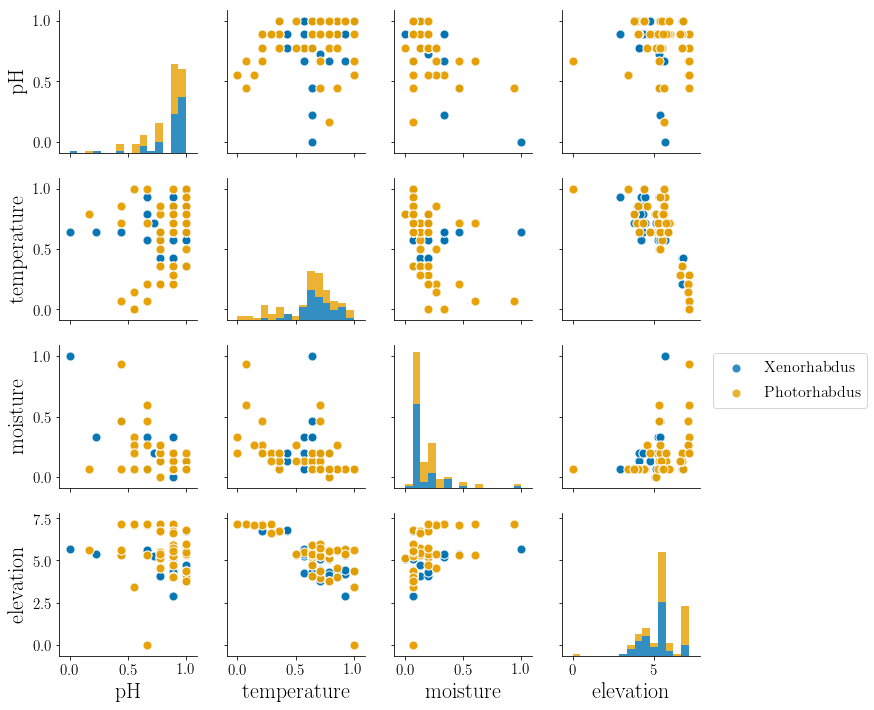

In [7]:
ax = sns.pairplot(metadata, vars=['pH', 'temperature', 'moisture', 'elevation'], hue='genus', palette=colours[5::-4], kind='scatter',
             diag_kind='hist', diag_kws=dict(alpha=0.8, bins=15), plot_kws=dict(alpha=0.8, s=80))
ax._legend.remove()
plt.legend(fontsize=16, bbox_to_anchor=(1.04,1), loc="upper left")

For the rest of the geographical metadata, the situation is similar.

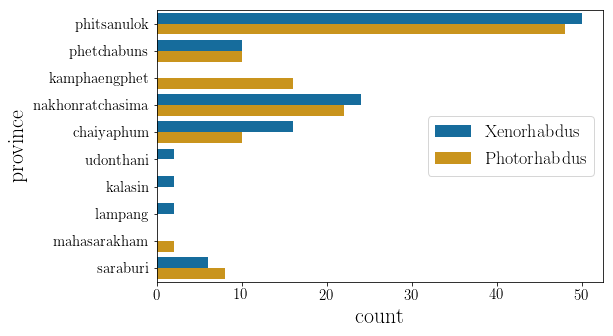

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(y='province', data=metadata, hue='genus', palette=colours[5::-4])
plt.legend(fontsize=18)

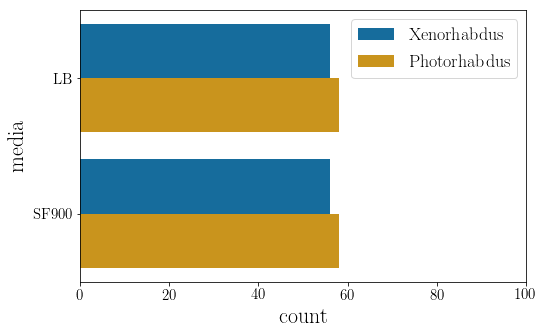

In [9]:
fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(y='media', data=metadata, hue='genus', palette=colours[5::-4])
plt.xlim(0,100)
plt.legend(fontsize=18)

Text(0,0.5,'soil type')

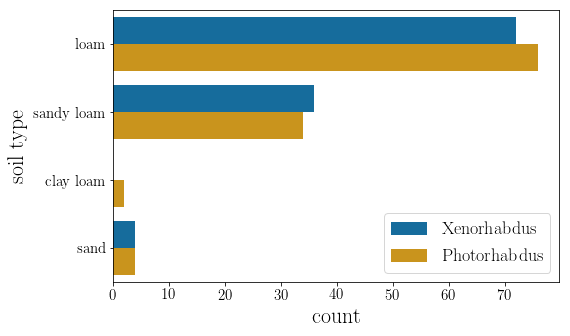

In [10]:
fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(y='soiltype', data=metadata, hue='genus', palette=colours[5::-4])
plt.legend(fontsize=18)
plt.ylabel('soil type')

As a last step, we need to turn these categorical features into numerical ones. Since there is no specific ordering among the feature values of any of these columns, we apply one-hot encoding.

In [11]:
metadata = pd.get_dummies(metadata, columns=['media', 'province', 'soiltype'])
metadata.head()

,strain,genus,species,elevation,pH,temperature,moisture,media_LB,media_SF900,province_chaiyaphum,...,province_mahasarakham,province_nakhonratchasima,province_phetchabuns,province_phitsanulok,province_saraburi,province_udonthani,soiltype_clay loam,soiltype_loam,soiltype_sand,soiltype_sandy loam
19777,409,Xenorhabdus,stockiae,5.231109,0.888889,0.714286,0.066667,1,0,0,...,0,0,0,1,0,0,0,1,0,0
19789,409,Xenorhabdus,stockiae,5.231109,0.888889,0.714286,0.066667,0,1,0,...,0,0,0,1,0,0,0,1,0,0
19817,432,Photorhabdus,luminescens,5.497168,0.777778,0.571429,0.133333,1,0,0,...,0,0,0,1,0,0,0,0,0,1
19818,433,Photorhabdus,luminescens,5.497168,0.888889,0.642857,0.066667,1,0,0,...,0,0,0,1,0,0,0,0,0,1
19819,434,Photorhabdus,luminescens,5.545177,0.888889,0.642857,0.066667,1,0,0,...,0,0,0,1,0,0,0,0,0,1


We save this for future use.

In [12]:
metadata.to_csv('../data/model/metadata.csv')

## Metabolite data

### Rescaling and removal of poor predictors

We start by peeking at a few columns of the data.

In [12]:
data_int[data_int.columns[:10]].describe()

,0,1,2,3,4,5,6,7,8,9
count,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000
mean,48.076923,196.560440,18.129121,44.395604,235.387363,180.442308,28.711538,382.513736,1221.489011,272.335165
std,896.676271,998.021017,345.881582,644.709812,414.779321,2760.100777,521.092904,1005.280248,3892.201639,1389.553042
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,93.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,377.250000,0.000000,0.000000,0.000000,31.000000,29.000000
max,17104.000000,9861.000000,6599.000000,12299.000000,5638.000000,51257.000000,9942.000000,5773.000000,30253.000000,10452.000000


In [13]:
data_auc[data_auc.columns[:10]].describe()

,0,1,2,3,4,5,6,7,8,9
count,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000
mean,140.554011,706.054003,59.092418,150.725187,670.925295,521.973140,95.691795,116.704959,1456.295861,665.876896
std,2609.647928,3497.228104,1127.411473,2472.620855,1464.161092,7735.987197,1752.560518,307.936574,4598.554307,3548.824653
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,62.445250,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,836.579500,0.000000,0.000000,0.000000,11.105500,42.487250
max,49773.375000,32889.396500,21509.640000,47184.761000,20737.809000,142852.257000,33438.115000,1610.047000,34814.323000,30485.268000


In [14]:
data_zauc[data_zauc.columns[:10]].describe()

,0,1,2,3,4,5,6,7,8,9
count,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000
mean,140.554011,706.054003,59.092418,150.520782,670.925295,521.973140,95.231952,116.510342,1421.750907,665.173688
std,2609.647928,3497.228104,1127.411473,2472.630257,1464.161092,7735.987197,1752.581532,308.002694,4593.569615,3548.953034
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,62.445250,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,836.579500,0.000000,0.000000,0.000000,8.141250,35.909750
max,49773.375000,32889.396500,21509.640000,47184.761000,20737.809000,142852.257000,33438.115000,1610.047000,34814.323000,30485.268000


We observe that the metabolite intensity and AUC are extremely skewed and span several orders of magnitude. We transform them to log scale for ease of visualisation&mdash;recall that tree-based algorithms are robust to feature scalings and outliers.

In [15]:
data_int = np.log1p(data_int)
data_auc = np.log1p(data_auc)
data_zauc = np.log1p(data_zauc)

Let's visualise what a single sample from the intensity dataset looks like

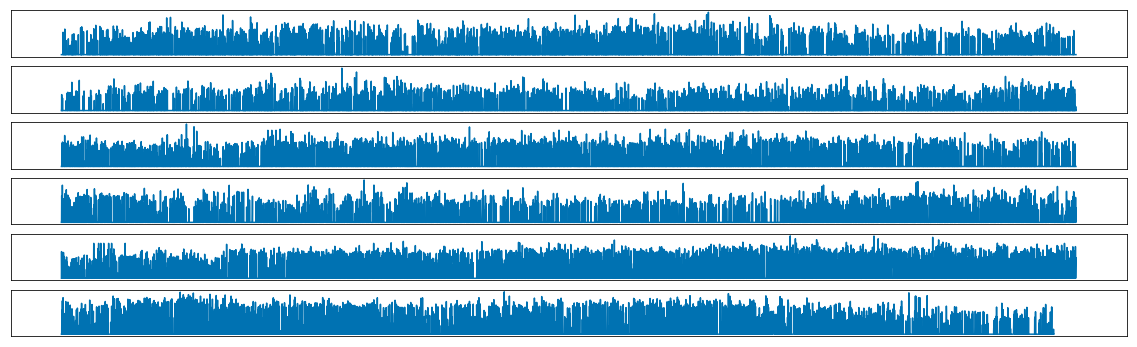

In [15]:
fig, axes = plt.subplots(6,figsize=(20,12), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(data_int.iloc[0].values[7500*i:min(7500*(i+1), data_int.shape[1])], c=colours[5])
    ax.set_yticks([])
    ax.set_xticks([])

And one single peak across samples

Text(0.5,0,'log intensity peak 3')

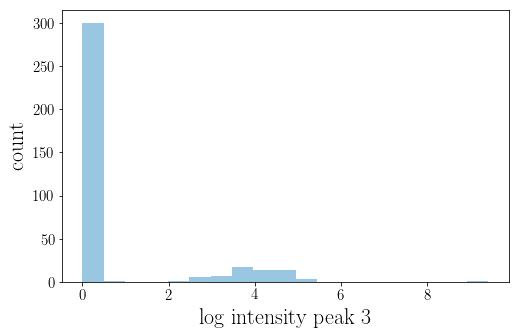

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(data_int[data_int.columns[3]], kde=False, color=colours[5])
plt.ylabel('count')
plt.xlabel('log intensity peak '+data_int.columns[3])

Now, we remove any constant columns (zero variance) from the metabolite data, since they will not contribute to the classification. In this case, the constant will be equal to zero, indicating that a certain metabolite is not present in *any* of the samples. Furthermore, we can remove near-zero-variance features, *i.e.*, metabolites that are only present in very few of the samples, anticipating that they will also be poor class predictors. We set the threshold at 20 values, which is ca. 10% of the samples.

We also recall that we do not have metadata for all samples, and therefore some of them will not contribute to training the model. For this reason we apply the column removal step only considering the labelled samples; in other words, if a certain compound has (near-) zero variance, we remove its corresponding column even if some unlabelled samples have (many) non-zero values. The removal applies to all samples, however.

In [16]:
# only consider samples with metadata

data_int2 = data_int.loc[metadata.index]
data_auc2 = data_auc.loc[metadata.index]
data_zauc2 = data_zauc.loc[metadata.index]

In [17]:
nothing_int = [col for col in data_int.columns if len(data_int2[col].nonzero()[0]) == 0]
nothing_auc = [col for col in data_auc.columns if len(data_auc2[col].nonzero()[0]) == 0]
nothing_zauc = [col for col in data_zauc.columns if len(data_zauc2[col].nonzero()[0]) == 0]

print('Number of constant columns in intensity data: %i' % len(nothing_int))
print('Number of constant columns in AUC data: %i' % len(nothing_auc))
print('Number of constant columns in zeroed AUC data: %i' % len(nothing_zauc))

Number of constant columns in intensity data: 2667
Number of constant columns in AUC data: 2626
Number of constant columns in zeroed AUC data: 2716


In [18]:
data_int_Z = data_int.drop(nothing_int, axis=1)
data_auc_Z = data_auc.drop(nothing_auc, axis=1)
data_zauc_Z = data_zauc.drop(nothing_zauc, axis=1)

In [19]:
nothing_int = [col for col in data_int.columns if len(data_int2[col].nonzero()[0]) <= 20]
nothing_auc = [col for col in data_auc.columns if len(data_auc2[col].nonzero()[0]) <= 20]
nothing_zauc = [col for col in data_zauc.columns if len(data_zauc2[col].nonzero()[0]) <= 20]

print('Number of near-zero-variance columns in intensity data: %i' % len(nothing_int))
print('Number of near-zero-variance columns in AUC data: %i' % len(nothing_auc))
print('Number of near-zero-variance columns in zeroed AUC data: %i' % len(nothing_zauc))

Number of near-zero-variance columns in intensity data: 14449
Number of near-zero-variance columns in AUC data: 14163
Number of near-zero-variance columns in zeroed AUC data: 14752


In [20]:
data_int_NZ = data_int.drop(nothing_int, axis=1)
data_auc_NZ = data_auc.drop(nothing_auc, axis=1)
data_zauc_NZ = data_zauc.drop(nothing_zauc, axis=1)

We save both the dataset with removal of zero-variance features and the one with removal of near-zero-variance features for each type of data, for future comparison.

In [26]:
data_int_Z.to_csv('../data/model/data_int_Z.csv')
data_auc_Z.to_csv('../data/model/data_auc_Z.csv')
data_zauc_Z.to_csv('../data/model/data_zauc_Z.csv')

data_int_NZ.to_csv('../data/model/data_int_NZ.csv')
data_auc_NZ.to_csv('../data/model/data_auc_NZ.csv')
data_zauc_NZ.to_csv('../data/model/data_zauc_NZ.csv')

### Clustering of correlated features

Tree-based methods are also robust to highly correlated features: for a given split, they choose one of them ignoring the others. This robustness is good from a performance point of view, but the ignored features will not show up in an importance ranking, so that we may lose valuable information when interpreting the model. For this reason, we decide to cluster highly correlated features, removing from the dataset all but one member of any one cluster, but saving the cluster themselves, in order to go back to this data after determining the feature importances.

We do this for the datasets with removal of near-zero-variance features, for two correlation thresholds: 0.99 and 0.95.

**WARNING:** This is a memory-intensive process.

In [11]:
def searchcluster(column, links):
    cluster = [column]
    
    found = links[links.col1 == column].col2.values.tolist()
    
    cluster.extend(found)
    
    while len(found)>0:
        found2 = links[links.col1 == found[0]].col2.values
        found2 = np.setdiff1d(found2,cluster).tolist()
        found.extend(found2)
        cluster.extend(found2)
        found.remove(found[0])
    return cluster

#### Intensity data

We start by obtaining the correlation matrix of the dataset.

In [4]:
corrmatrix = data_int_NZ.corr()
corrmatrix.head()

,3,4,7,8,9,10,11,12,13,16,...,44824,44825,44827,44829,44830,44831,44832,44833,44834,44835
3,1.000000,0.109281,-0.178056,-0.184429,-0.113124,-0.381767,-0.123714,0.453836,0.095157,-0.022428,...,0.109598,0.006696,-0.009274,0.087997,0.414920,0.166689,0.193668,0.062510,0.063497,0.035290
4,0.109281,1.000000,-0.045433,-0.072321,-0.001930,-0.124536,-0.092990,0.145530,0.414635,0.190070,...,0.056922,0.437089,0.076056,0.395492,0.221354,0.071303,0.067063,-0.001001,-0.022691,0.463866
7,-0.178056,-0.045433,1.000000,0.598218,0.269298,0.405113,0.095899,-0.411802,0.077747,0.085698,...,-0.131957,0.028953,0.002611,0.021390,-0.216956,-0.202139,-0.211420,-0.077814,-0.063961,0.044311
8,-0.184429,-0.072321,0.598218,1.000000,0.376614,0.393442,-0.003811,-0.424493,0.000048,0.036664,...,-0.096665,-0.004609,0.029484,-0.024239,-0.241673,-0.130833,-0.139113,-0.019606,-0.019099,-0.004183
9,-0.113124,-0.001930,0.269298,0.376614,1.000000,0.268072,-0.001185,-0.275045,0.035769,0.029817,...,0.062795,0.044746,0.128153,0.036428,-0.169372,0.127369,0.171970,0.049209,0.078293,0.001451


We find which columns are members of a cluster, *any* cluster.

In [5]:
in_cl099 = [column for column in corrmatrix.columns if sum(corrmatrix[column].abs() > 0.99)>1]
in_cl095 = [column for column in corrmatrix.columns if sum(corrmatrix[column].abs() > 0.95)>1]
in_cl090 = [column for column in corrmatrix.columns if sum(corrmatrix[column].abs() > 0.9)>1]

We take a reduced correlation matrix, considering only columns that are members of clusters. We save a list of pairwise links for future use in a network visualisation.

In [6]:
corr099 = data_int_NZ[in_cl099].corr()
corr095 = data_int_NZ[in_cl095].corr()
corr090 = data_int_NZ[in_cl090].corr()

In [7]:
links099 = corr099.stack().reset_index()
links099.columns = ['col1', 'col2', 'corr']
links095 = corr095.stack().reset_index()
links095.columns = ['col1', 'col2', 'corr']
links090 = corr090.stack().reset_index()
links090.columns = ['col1', 'col2', 'corr']

links099.head()

,col1,col2,corr
0,12,12,1.000000
1,12,29,-0.406414
2,12,47,-0.250751
3,12,70,-0.267992
4,12,84,-0.856772


In [9]:
links_filtered099=links099.loc[ (np.abs(links099['corr']) > 0.99) & (links099['col1'] != links099['col2']) ]
links_filtered095=links095.loc[ (np.abs(links095['corr']) > 0.95) & (links095['col1'] != links095['col2']) ]
links_filtered090=links090.loc[ (np.abs(links090['corr']) > 0.9) & (links090['col1'] != links090['col2']) ]

links_filtered099.head()

,col1,col2,corr
1403,12,28754,0.996142
2734,29,1025,0.996293
7372,47,37806,0.990106
8540,70,12946,0.992204
12227,84,32450,0.992771


In [10]:
links_filtered099.to_csv('../data/links099_int.csv')
links_filtered095.to_csv('../data/links095_int.csv')
links_filtered090.to_csv('../data/links090_int.csv')

Now we separate the actual clusters and their given members.

In [12]:
clusters099 = []
cols = links_filtered099.col1.values
cols2 = links_filtered099.col1.values
for column in cols:
    if column not in cols2:
        continue
    cluster = searchcluster(column, links_filtered099)
    cols2 = np.setdiff1d(cols2,cluster)
    clusters099.append(cluster)
    
print('Number of clusters with threshold 0.99: %i' % len(clusters099))

Number of clusters with threshold 0.99: 609


In [14]:
clusters095 = []
cols = links_filtered095.col1.values
cols2 = links_filtered095.col1.values
for column in cols:
    if column not in cols2:
        continue
    cluster = searchcluster(column, links_filtered095)
    cols2 = np.setdiff1d(cols2,cluster)
    clusters095.append(cluster)

print('Number of clusters with threshold 0.95: %i' % len(clusters095))

Number of clusters with threshold 0.95: 1178


In [15]:
clusters090 = []
cols = links_filtered090.col1.values
cols2 = links_filtered090.col1.values
for column in cols:
    if column not in cols2:
        continue
    cluster = searchcluster(column, links_filtered090)
    cols2 = np.setdiff1d(cols2,cluster)
    clusters090.append(cluster)

print('Number of clusters with threshold 0.90: %i' % len(clusters090))

Number of clusters with threshold 0.90: 1311


We finally remove all but one member of every cluster, and save the resulting dataset.

In [13]:
drop099 = []
for x in clusters099:
    drop099.extend(list(map(str, x[1:])))
    
data_int_099 = data_int_NZ.drop(drop099, axis=1)

data_int_099.to_csv('../data/model/data_int_099.csv')

In [16]:
drop095 = []
for x in clusters095:
    drop095.extend(list(map(str, x[1:])))
    
data_int_095 = data_int_NZ.drop(drop095, axis=1)

data_int_095.to_csv('../data/model/data_int_095.csv')

In [17]:
drop090 = []
for x in clusters090:
    drop090.extend(list(map(str, x[1:])))
    
data_int_090 = data_int_NZ.drop(drop090, axis=1)

data_int_090.to_csv('../data/model/data_int_090.csv')

#### AUC data

We start by obtaining the correlation matrix of the dataset.

In [19]:
corrmatrix = data_auc_NZ.corr()

In [20]:
corrmatrix.head()

,3,4,7,8,9,10,11,12,13,16,...,44824,44825,44827,44829,44830,44831,44832,44833,44834,44835
3,1.000000,0.117007,-0.156911,-0.150367,-0.079332,-0.415777,-0.128657,0.443976,0.087506,0.031878,...,0.118129,-0.006491,-0.004430,0.067373,0.383341,0.160449,0.123000,0.102598,0.103587,0.011084
4,0.117007,1.000000,-0.058498,-0.084942,-0.007788,-0.149104,-0.101978,0.180674,0.413428,0.213327,...,0.064271,0.429839,0.081999,0.384449,0.240133,0.062137,0.062299,0.006499,-0.007263,0.456285
7,-0.156911,-0.058498,1.000000,0.572860,0.279382,0.384045,0.106053,-0.376650,0.040023,0.006777,...,-0.138010,0.026769,0.022621,0.008287,-0.198146,-0.213532,-0.188461,-0.050542,-0.057962,0.028088
8,-0.150367,-0.084942,0.572860,1.000000,0.397003,0.369870,0.010962,-0.393418,0.012009,-0.023976,...,-0.096860,0.012073,0.057702,-0.035809,-0.214490,-0.150547,-0.126172,-0.034046,-0.017611,0.015154
9,-0.079332,-0.007788,0.279382,0.397003,1.000000,0.298946,-0.001096,-0.320142,-0.003282,-0.035315,...,0.005705,0.025212,0.117331,0.036779,-0.175996,0.140625,0.204140,0.030772,0.048990,-0.033766


We find which columns are members of a cluster, *any* cluster.

In [21]:
in_cl099 = [column for column in corrmatrix.columns if sum(corrmatrix[column].abs() > 0.99)>1]
in_cl095 = [column for column in corrmatrix.columns if sum(corrmatrix[column].abs() > 0.95)>1]
in_cl090 = [column for column in corrmatrix.columns if sum(corrmatrix[column].abs() > 0.9)>1]

We take a reduced correlation matrix, considering only columns that are members of clusters. We save a list of pairwise links for future use in a network visualisation.

In [22]:
corr099 = data_auc_NZ[in_cl099].corr()
corr095 = data_auc_NZ[in_cl095].corr()
corr090 = data_auc_NZ[in_cl090].corr()

In [23]:
links099 = corr099.stack().reset_index()
links099.columns = ['col1', 'col2', 'corr']
links095 = corr095.stack().reset_index()
links095.columns = ['col1', 'col2', 'corr']
links090 = corr090.stack().reset_index()
links090.columns = ['col1', 'col2', 'corr']

links099.head()

,col1,col2,corr
0,12,12,1.000000
1,12,29,-0.380066
2,12,190,-0.083151
3,12,384,0.126252
4,12,410,0.147638


In [24]:
links_filtered099=links099.loc[ (np.abs(links099['corr']) > 0.99) & (links099['col1'] != links099['col2']) ]
links_filtered095=links095.loc[ (np.abs(links095['corr']) > 0.95) & (links095['col1'] != links095['col2']) ]
links_filtered090=links090.loc[ (np.abs(links090['corr']) > 0.9) & (links090['col1'] != links090['col2']) ]

links_filtered099.head()

,col1,col2,corr
293,12,28754,0.993804
492,29,1025,0.998821
989,190,2115,0.991208
1069,190,12754,0.990546
1336,190,35569,0.993667


In [25]:
links_filtered099.to_csv('../data/links099_auc.csv')
links_filtered095.to_csv('../data/links095_auc.csv')
links_filtered090.to_csv('../data/links090_auc.csv')

Now we separate the actual clusters and their given members.

In [26]:
clusters099 = []
cols = links_filtered099.col1.values
cols2 = links_filtered099.col1.values
for column in cols:
    if column not in cols2:
        continue
    cluster = searchcluster(column, links_filtered099)
    cols2 = np.setdiff1d(cols2,cluster)
    clusters099.append(cluster)
    
print('Number of clusters with threshold 0.99: %i' % len(clusters099))

Number of clusters with threshold 0.99: 175


In [27]:
clusters095 = []
cols = links_filtered095.col1.values
cols2 = links_filtered095.col1.values
for column in cols:
    if column not in cols2:
        continue
    cluster = searchcluster(column, links_filtered095)
    cols2 = np.setdiff1d(cols2,cluster)
    clusters095.append(cluster)

print('Number of clusters with threshold 0.95: %i' % len(clusters095))

Number of clusters with threshold 0.95: 1054


In [28]:
clusters090 = []
cols = links_filtered090.col1.values
cols2 = links_filtered090.col1.values
for column in cols:
    if column not in cols2:
        continue
    cluster = searchcluster(column, links_filtered090)
    cols2 = np.setdiff1d(cols2,cluster)
    clusters090.append(cluster)

print('Number of clusters with threshold 0.90: %i' % len(clusters090))

Number of clusters with threshold 0.90: 1270


We finally remove all but one member of every cluster, and save the resulting dataset.

In [29]:
drop099 = []
for x in clusters099:
    drop099.extend(list(map(str, x[1:])))
    
data_auc_099 = data_auc_NZ.drop(drop099, axis=1)

data_auc_099.to_csv('../data/model/data_auc_099.csv')

In [30]:
drop095 = []
for x in clusters095:
    drop095.extend(list(map(str, x[1:])))
    
data_auc_095 = data_auc_NZ.drop(drop095, axis=1)

data_auc_095.to_csv('../data/model/data_auc_095.csv')

In [31]:
drop090 = []
for x in clusters090:
    drop090.extend(list(map(str, x[1:])))
    
data_auc_090 = data_auc_NZ.drop(drop090, axis=1)

data_auc_090.to_csv('../data/model/data_auc_090.csv')

#### Zeroed AUC data

We start by obtaining the correlation matrix of the dataset.

In [33]:
corrmatrix = data_zauc_NZ.corr()

In [34]:
corrmatrix.head()

,3,4,7,8,9,10,11,12,13,16,...,44824,44825,44827,44829,44830,44831,44832,44833,44834,44835
3,1.000000,0.108550,-0.166967,-0.169697,-0.073474,-0.407935,-0.122661,0.442838,0.083154,0.023746,...,0.099348,-0.008651,0.000088,0.068016,0.388988,0.126047,0.111096,0.111046,0.109691,0.012503
4,0.108550,1.000000,-0.051155,-0.090007,0.009373,-0.147544,-0.101121,0.176458,0.413428,0.213327,...,0.061921,0.429839,0.076448,0.387000,0.240133,0.059661,0.080297,0.005289,-0.009874,0.458139
7,-0.166967,-0.051155,1.000000,0.591054,0.287745,0.388247,0.101624,-0.387061,0.042510,0.013640,...,-0.132656,0.034408,0.026978,0.018111,-0.196162,-0.202755,-0.176040,-0.060072,-0.064763,0.038204
8,-0.169697,-0.090007,0.591054,1.000000,0.402045,0.378447,0.005174,-0.414167,0.007318,-0.005253,...,-0.085392,0.013499,0.054468,-0.022070,-0.227449,-0.132620,-0.101164,-0.036079,-0.036588,0.016330
9,-0.073474,0.009373,0.287745,0.402045,1.000000,0.287205,0.008489,-0.302262,0.011931,-0.019224,...,-0.004209,0.035414,0.118670,0.044376,-0.156144,0.089251,0.181120,0.014313,0.042610,-0.019397


We find which columns are members of a cluster, *any* cluster.

In [35]:
in_cl099 = [column for column in corrmatrix.columns if sum(corrmatrix[column].abs() > 0.99)>1]
in_cl095 = [column for column in corrmatrix.columns if sum(corrmatrix[column].abs() > 0.95)>1]
in_cl090 = [column for column in corrmatrix.columns if sum(corrmatrix[column].abs() > 0.9)>1]

We take a reduced correlation matrix, considering only columns that are members of clusters. We save a list of pairwise links for future use in a network visualisation.

In [37]:
corr099 = data_zauc_NZ[in_cl099].corr()
corr095 = data_zauc_NZ[in_cl095].corr()
corr090 = data_zauc_NZ[in_cl090].corr()

In [38]:
links099 = corr099.stack().reset_index()
links099.columns = ['col1', 'col2', 'corr']
links095 = corr095.stack().reset_index()
links095.columns = ['col1', 'col2', 'corr']
links090 = corr090.stack().reset_index()
links090.columns = ['col1', 'col2', 'corr']

links099.head()

,col1,col2,corr
0,12,12,1.000000
1,12,29,-0.390829
2,12,85,-0.256677
3,12,103,-0.324104
4,12,106,-0.263684


In [39]:
links_filtered099=links099.loc[ (np.abs(links099['corr']) > 0.99) & (links099['col1'] != links099['col2']) ]
links_filtered095=links095.loc[ (np.abs(links095['corr']) > 0.95) & (links095['col1'] != links095['col2']) ]
links_filtered090=links090.loc[ (np.abs(links090['corr']) > 0.9) & (links090['col1'] != links090['col2']) ]

links_filtered099.head()

,col1,col2,corr
450,12,28754,0.993848
712,29,1025,0.998800
1376,85,106,0.991310
2177,103,8332,0.997594
2746,106,85,0.991310


In [40]:
links_filtered099.to_csv('../data/links099_zauc.csv')
links_filtered095.to_csv('../data/links095_zauc.csv')
links_filtered090.to_csv('../data/links090_zauc.csv')

Now we separate the actual clusters and their given members.

In [41]:
clusters099 = []
cols = links_filtered099.col1.values
cols2 = links_filtered099.col1.values
for column in cols:
    if column not in cols2:
        continue
    cluster = searchcluster(column, links_filtered099)
    cols2 = np.setdiff1d(cols2,cluster)
    clusters099.append(cluster)
    
print('Number of clusters with threshold 0.99: %i' % len(clusters099))

Number of clusters with threshold 0.99: 218


In [42]:
clusters095 = []
cols = links_filtered095.col1.values
cols2 = links_filtered095.col1.values
for column in cols:
    if column not in cols2:
        continue
    cluster = searchcluster(column, links_filtered095)
    cols2 = np.setdiff1d(cols2,cluster)
    clusters095.append(cluster)

print('Number of clusters with threshold 0.95: %i' % len(clusters095))

Number of clusters with threshold 0.95: 1038


In [43]:
clusters090 = []
cols = links_filtered090.col1.values
cols2 = links_filtered090.col1.values
for column in cols:
    if column not in cols2:
        continue
    cluster = searchcluster(column, links_filtered090)
    cols2 = np.setdiff1d(cols2,cluster)
    clusters090.append(cluster)

print('Number of clusters with threshold 0.90: %i' % len(clusters090))

Number of clusters with threshold 0.90: 1290


We finally remove all but one member of every cluster, and save the resulting dataset.

In [44]:
drop099 = []
for x in clusters099:
    drop099.extend(list(map(str, x[1:])))
    
data_zauc_099 = data_zauc_NZ.drop(drop099, axis=1)

data_zauc_099.to_csv('../data/model/data_zauc_099.csv')

In [45]:
drop095 = []
for x in clusters095:
    drop095.extend(list(map(str, x[1:])))
    
data_zauc_095 = data_zauc_NZ.drop(drop095, axis=1)

data_zauc_095.to_csv('../data/model/data_zauc_095.csv')

In [46]:
drop090 = []
for x in clusters090:
    drop090.extend(list(map(str, x[1:])))
    
data_zauc_090 = data_zauc_NZ.drop(drop090, axis=1)

data_zauc_090.to_csv('../data/model/data_zauc_090.csv')